# Decision Trees and Random Forests

In this tutorial, we will learn cover decision trees and random forests. These are supervised learning algorithms that can be used for classification or regression.

The code below will install and load the required packages and data sets for this tutorial. We will need the `vip`, `ranger` and `rpart.plot` packages. 

In [1]:
install.packages(c('vip', 'ranger', 'rpart.plot'), 
                 repos = 'https://mran.microsoft.com/snapshot/2023-01-01/')

Installing packages into ‘/home/repl/renv/library/R-4.2/x86_64-pc-linux-gnu’
(as ‘lib’ is unspecified)



In [2]:
library(tidymodels)
library(vip)
library(rpart.plot)

# Telecommunications customer churn data
churn_df <- 
  readRDS(url('https://gmubusinessanalytics.netlify.app/data/churn_data.rds'))

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.1      ✔ recipes      1.0.3 
✔ dials        1.1.0      ✔ rsample      1.1.0 
✔ dplyr        1.0.10     ✔ tibble       3.1.8 
✔ ggplot2      3.4.0      ✔ tidyr        1.2.1 
✔ infer        1.0.3      ✔ tune         1.0.1 
✔ modeldata    1.0.1      ✔ workflows    1.1.2 
✔ parsnip      1.0.3      ✔ workflowsets 1.0.0 
✔ purrr        0.3.5      ✔ yardstick    1.1.0 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ purrr::discard() masks scales::discard()
✖ dplyr::filter()  masks stats::filter()
✖ dplyr::lag()     masks stats::lag()
✖ recipes::step()  masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages


Attaching package: ‘vip’


The following object is masked from ‘package:utils’:

    vi


Loading required package: rpart


Attaching package: ‘rpart’


The following object is masked from ‘package:dials’:

    p

# Data

We will be working with the `churn_df` data frame in this lesson. Take a moment to explore this data set below.

A row in this data frame represents a customer at a telecommunications company. Each customer has purchased phone and internet services from this company.

The response variable in this data is `churn` which indicates whether the customer terminated their services.

In [3]:
churn_df

churn,enrollment_discount,tv_plan,movie_plan,monthly_charges,late_payments
<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>
yes,yes,yes,no,63.85686,2
no,no,no,no,61.20185,0
yes,yes,no,no,93.74028,1
yes,no,yes,yes,110.69285,5
no,no,yes,no,42.45980,4
no,no,no,no,76.04233,0
no,yes,yes,no,66.10153,0
yes,yes,yes,no,109.64420,0
no,yes,no,yes,78.71100,0


# Decision Trees

<table cellSpacing = 20>
    <tr>
      <td>
          <img 
             src="./files/decision_tree_5.png"
             width="auto"
             height="auto"
          />
      </td>
      <td>
          <img 
             src="./files/tree_diagram.png"
             width="auto"
             height="auto"
          />
      </td>      
    </tr>
</table>

To demonstrate fitting decision trees, we will use the `churn_df` data set and predict `churn` using all available predictor variables.

A decision tree is specified with the `decision_tree()` function from `tidymodels` and has three hyperparameters, `cost_complexity`, `tree_depth`, and `min_n`. Since we will need to perform hyperparameter tuning, we will create cross validation folds from our training data.

In [4]:
# Remember to always set your seed. Any integer will work
set.seed(314)

churn_split <- 
  initial_split(churn_df, prop = 0.75, strata = churn)

churn_training <- 
  churn_split %>% 
  training()

churn_test <- 
  churn_split %>% 
  testing()

# Create folds for cross validation on the training data set
## These will be used to tune model hyperparameters
set.seed(314)

churn_folds <- vfold_cv(churn_training, v = 5)

## Feature Engineering

Now we can create a feature engineering recipe for this data. We will train the following transformations on our training data.

- Remove skewness from numeric predictors
- Normalize all numeric predictors
- Create dummy variables for all nominal predictors

In [5]:
churn_recipe <- 
  recipe(churn ~ ., data = churn_training) %>% 
  step_YeoJohnson(all_numeric(), -all_outcomes()) %>% 
  step_normalize(all_numeric(), -all_outcomes()) %>% 
  step_dummy(all_nominal(), -all_outcomes())

<br>

Let's check to see if the feature engineering steps have been carried out correctly.

In [6]:
churn_recipe %>% 
  prep(training = churn_training) %>% 
  bake(new_data = NULL)

monthly_charges,late_payments,churn,enrollment_discount_no,tv_plan_no,movie_plan_no
<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
-0.47479690,-1.3835834,no,1,1,1
-1.24101904,1.0055085,no,1,0,1
-0.27900399,-1.3835834,no,0,0,1
0.21794921,-1.3835834,no,0,1,0
-1.46611692,-1.3835834,no,1,1,1
-1.26073976,0.6099686,no,1,1,0
-1.43140096,-0.4787131,no,1,0,1
0.42781555,-0.4787131,no,0,1,1
-0.22276048,-1.3835834,no,1,1,0


## Model Specification

Next, we specify a decision tree classifier with the following hyperparameters:

- `cost_complexity`: The cost complexity parameter (a.k.a. C<sub>p</sub> or $\lambda$)
- `tree_depth`: The maximum depth of a tree
- `min_n`: The minimum number of data points in a node that are required for the node to be split further.

To specify a decision tree model with `tidymodels`, we need the `decision_tree()` function. The hyperparameters of the model are arguments within the `decision_tree()` function and may be set to specify values. 

However, if tuning is required, then each of these parameters must be set to `tune()`.

We will be using the `rpart` engine since it will allow us to easily make plots of our decision tree models with the `rpart.plot()` function.

In [7]:
tree_model <- 
  decision_tree(cost_complexity = tune(),
                tree_depth = tune(),
                min_n = tune()) %>% 
  set_engine('rpart') %>% 
  set_mode('classification')

## Workflow

Next, we combine our model and recipe into a workflow to easily manage the model-building process.

In [8]:
tree_workflow <- 
  workflow() %>% 
  add_model(tree_model) %>% 
  add_recipe(churn_recipe)

## Hyperparameter Tuning

We will perform a grid search on the decision tree hyperparameters and select the best performing model based on the area under the ROC curve during cross validation.

For models with multiple hyperparameters, `tidymodels` has the `grid_regular()` function for automatically creating a tuning grid with combinations of suggested hyperparameter values.

The `grid_regular()` function takes the hyperparameters as arguments and a `levels` option. The `levels` option is used to determine the number of values to create for each unique hyperparameter. 

The number of rows in the grid will be `# levels`<sup>`# hyperparameters`</sup>

For example, with `levels = 2` and 3 model hyperparameters, the `grid_regular()` function will produce a tuning grid with 2<sup>3</sup> = 8 hyperparameter combinations. 


See the example below, where we create the `tree_grid` object.

In [9]:
## Create a grid of hyperparameter values to test
tree_grid <- 
  grid_regular(cost_complexity(),
               tree_depth(),
               min_n(), 
               levels = 2)

In [10]:
# View grid
tree_grid

cost_complexity,tree_depth,min_n
<dbl>,<int>,<int>
1e-10,1,2
1e-01,1,2
1e-10,15,2
1e-01,15,2
1e-10,1,40
1e-01,1,40
1e-10,15,40
1e-01,15,40


<br>

An equivalent way of building tuning grids is by using the `extract_parameter_set_dials()` function. When we pass a `parsnip` model object with `tune` parameters into the `extract_parameter_set_dials()` function, it will automatically extract them.

In [12]:
tree_grid <- 
  grid_regular(extract_parameter_set_dials(tree_model), levels = 2)

In [13]:
tree_grid

cost_complexity,tree_depth,min_n
<dbl>,<int>,<int>
1e-10,1,2
1e-01,1,2
1e-10,15,2
1e-01,15,2
1e-10,1,40
1e-01,1,40
1e-10,15,40
1e-01,15,40


## Tuning Hyperparameters with `tune_grid()`

To find the optimal combination of hyperparameters from our tuning grid, we will use the `tune_grid()` function.

As in the our KNN example, this function takes a model object or workflow as the first argument, cross valdidation folds for the second, and a tuning grid data frame as the third argument.

It is always sugguested to use `set.seed()` before using `tune_grid()` in order to be able to reproduce the results at a later time.

In [14]:
## Tune decision tree workflow
set.seed(314)

tree_tuning <- 
  tree_workflow %>% 
  tune_grid(resamples = churn_folds, grid = tree_grid)

<br>

To view the results of our hyperparameter tuning, we can use the `show_best()` function. We must pass the type of performance metric we would like to see into the `show_best()` function.

From the results below, we see that for each combination of hyperparameters in our grid, `tune_grid()` fit a decision tree model with that combination 5 times (since we have 5 folds in our cross validation object). 

The `mean` column in the results below indicates the average value of the performance metric that was obtained.

In [15]:
## Show the top 5 best models based on roc_auc metric
tree_tuning %>% show_best('roc_auc')

cost_complexity,tree_depth,min_n,.metric,.estimator,mean,n,std_err,.config
<dbl>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1e-10,15,40,roc_auc,binary,0.8518510,5,0.01501287,Preprocessor1_Model7
1e-10,1,2,roc_auc,binary,0.7488009,5,0.01601127,Preprocessor1_Model1
1e-01,1,2,roc_auc,binary,0.7488009,5,0.01601127,Preprocessor1_Model2
1e-01,15,2,roc_auc,binary,0.7488009,5,0.01601127,Preprocessor1_Model4
1e-10,1,40,roc_auc,binary,0.7488009,5,0.01601127,Preprocessor1_Model5


<br>

We can use the `select_best()` model to select the model from our tuning results that had the best overall performance. In the code below, we specify to select the best performing model based on the `roc_auc` metric.

We see that the model with a cost complexity of 1<sup>-10</sup>, a tree depth of 15, and minimum n of 40 produced the best model.

In [16]:
## Select best model based on roc_auc
best_tree <- 
  tree_tuning %>% 
  select_best(metric = 'roc_auc')

# View the best tree parameters
best_tree

cost_complexity,tree_depth,min_n,.config
<dbl>,<int>,<int>,<chr>
1e-10,15,40,Preprocessor1_Model7


## Finalize Workflow

The last step in hyperparameter tuning is to use `finalize_workflow()` to add our optimal model to our workflow object.

In [18]:
final_tree_workflow <- 
  tree_workflow %>% 
  finalize_workflow(best_tree)

## Visualize Results

In order to visualize our decision tree model, we will need to manually train our workflow object with the `fit()` function.

This step is optional, since visualizing the model is not necessary in all applications. However, if the goal is to understand **why** the model is predicting certain values, then it is recommended.

The next section shows how to fit the model with `last_fit()` for automatically obtaining test set performance.

### Fit the Model

Next we fit our workflow to the training data. This is done by passing our workflow object to the `fit()` function.

In [19]:
tree_wf_fit <- 
  final_tree_workflow %>% 
  fit(data = churn_training)

## Exploring our Trained Model

Once we have trained our model on our training data, we can study variable importance with the `vip()` function.

The first step is to extract the trained model from our workflow fit, `tree_wf_fit`. This can be done by passing `tree_wf_fit` to the `extract_fit_parsnip()` function. 

In [20]:
tree_fit <- 
  tree_wf_fit %>% 
  extract_fit_parsnip()

## Variable Importance

Next we pass `tree_fit` to the `vip()` function. This will return a `ggplot` object with the variable importance scores from our model. The importance scores are based on the splitting criteria of the trained decision tree.

We see from the results below, that `monthly_charges` by far is the most important predictor of churn.

In [22]:
# This code adjust the figure output size
options(repr.plot.width=11, repr.plot.height=8)

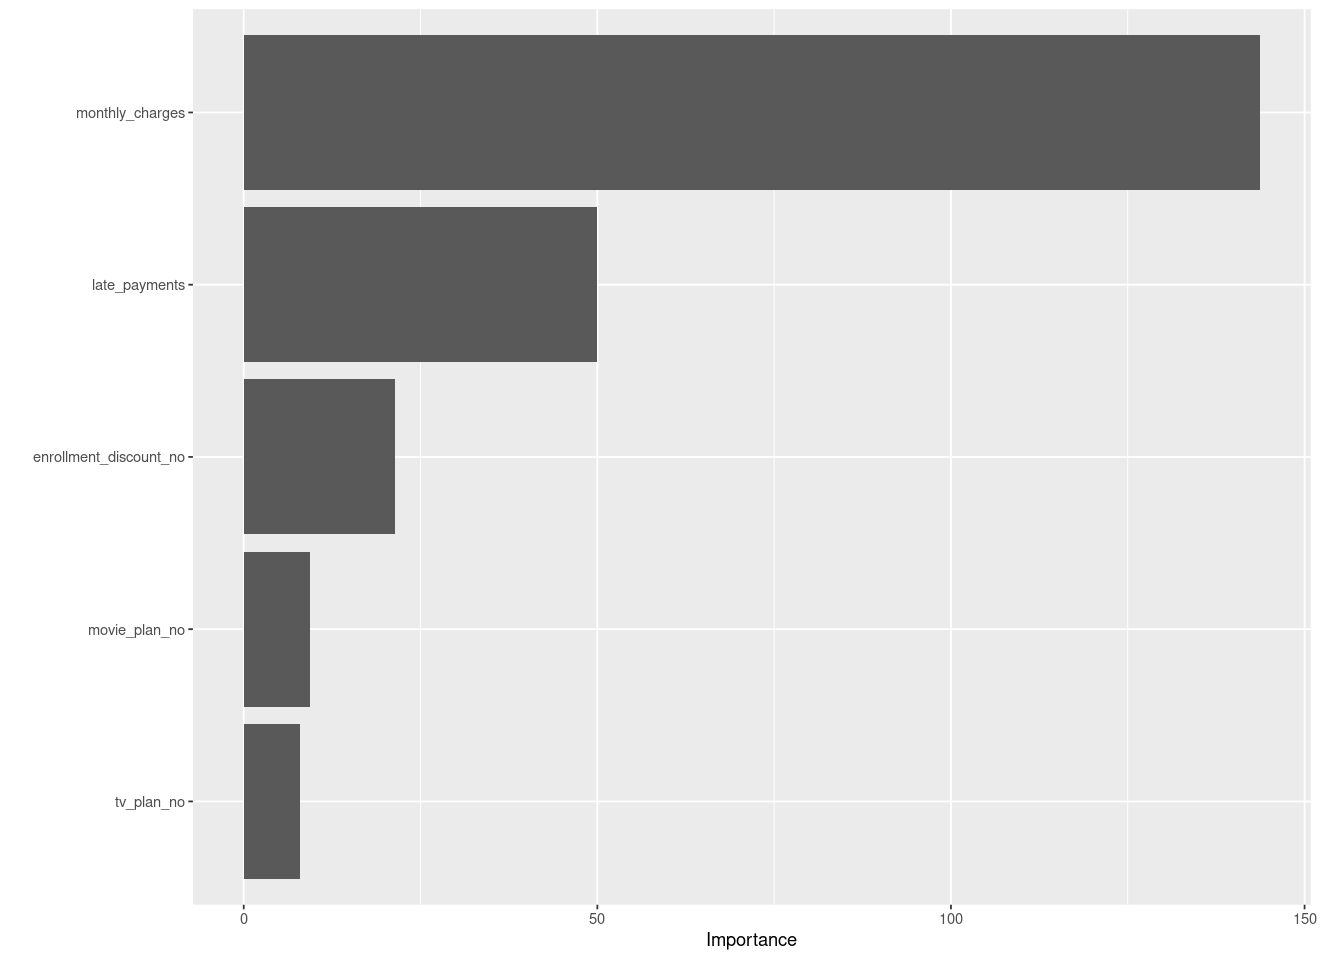

In [23]:
vip(tree_fit)

## Decision Tree Plot

We can visualize the trained decision tree by using the rpart.plot() function from the rpart.plot package. We must pass the `fit` object stored within `tree_fit` into the `rpart.plot()` function to make a decision tree plot.

When passing a `tidymodels` object into this function we also need to pass the addition parameter, `roundint = FALSE`. 
The option `extra = 2` shows the number of observations in the node that belong to the predicted class.

This visualization is a tool to communicate the prediction rules of the trained decision tree (the splits in the predictor space).

Many times, the decision tree plot will be quite large and difficult to read. This is the case for our example below. There are specialized packages in `R` for zooming into regions of a decision tree plot. However, we do not have time to get into the details this semester.

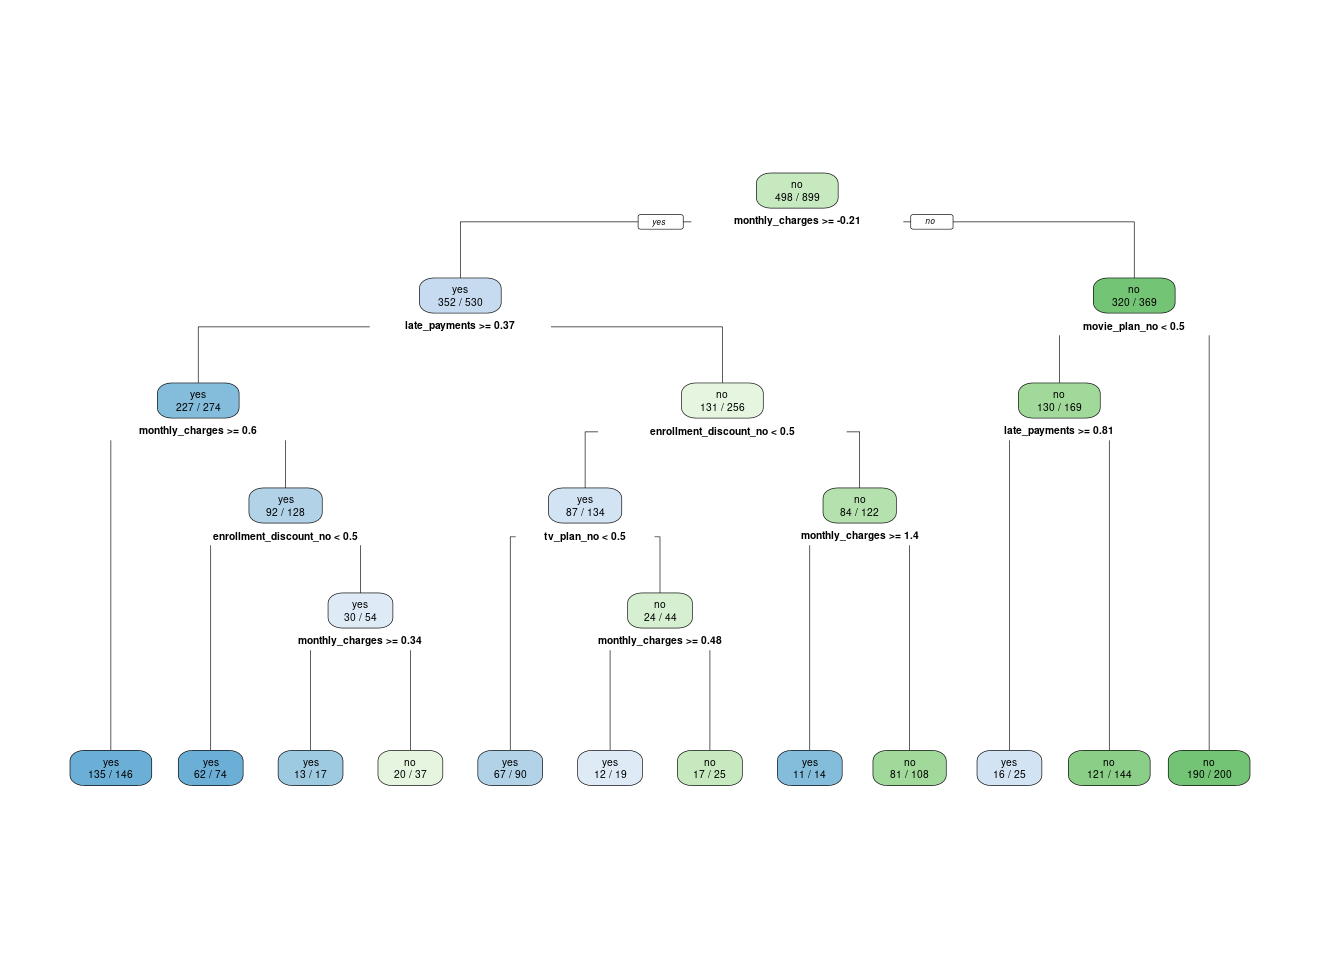

In [36]:
rpart.plot(tree_fit$fit, roundint = FALSE, extra = 2)

<br>



## Train and Evaluate With `last_fit()`

Next we fit our final model workflow to the training data and evaluate performance on the test data. 

The `last_fit()` function will fit our workflow to the training data and generate predictions on the test data as defined by our `churn_split` object.

In [37]:
tree_last_fit <- 
  final_tree_workflow %>% 
  last_fit(churn_split)

<br>

We can view our performance metrics on the test data

In [ ]:
tree_last_fit %>% collect_metrics()



## ROC Curve 

We can plot the ROC curve to visualize test set performance of our tuned decision tree

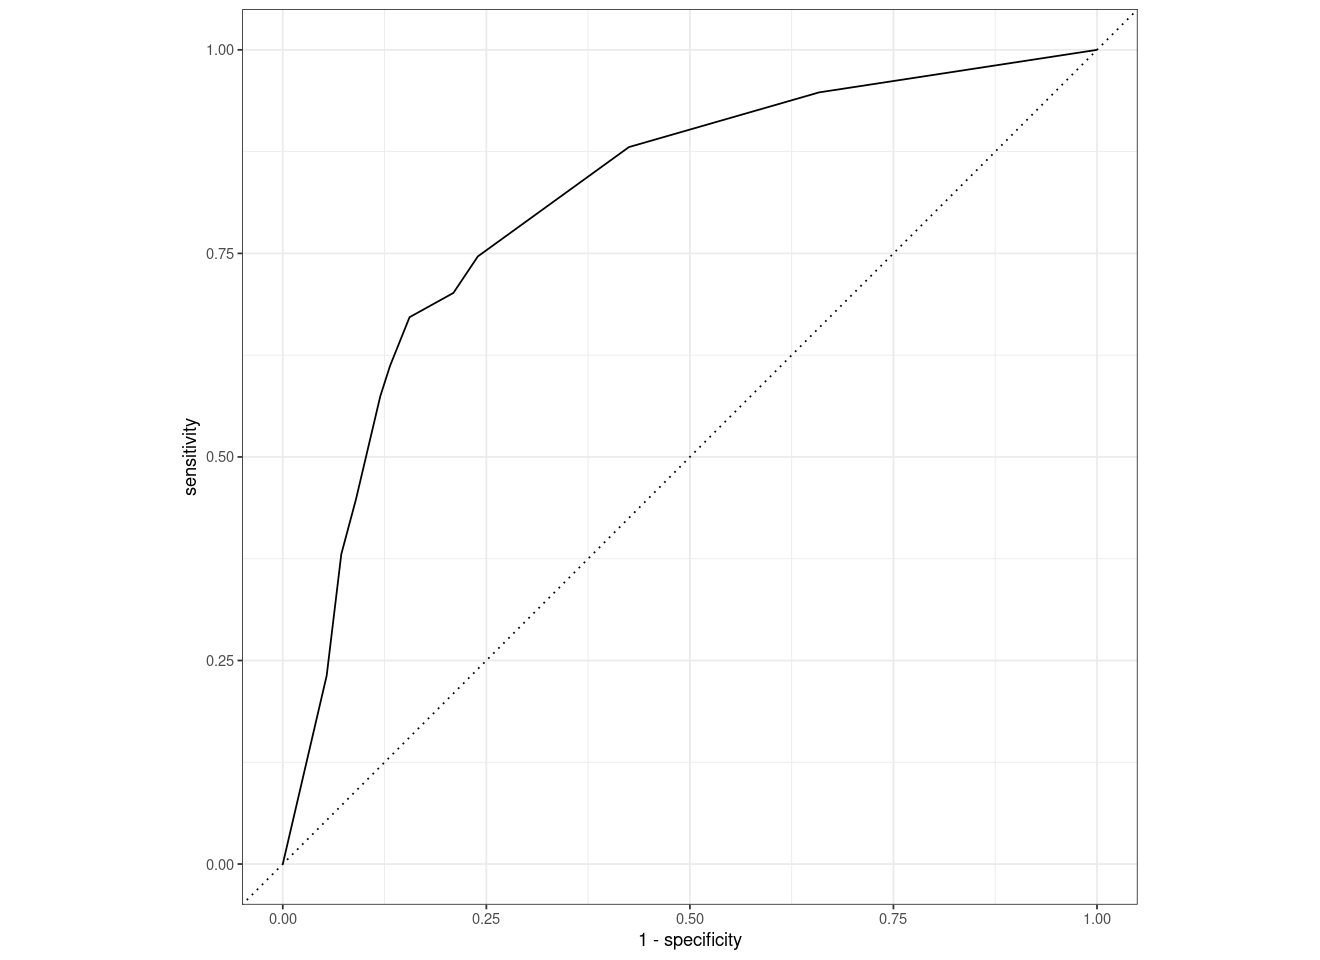

In [38]:
tree_last_fit %>% 
collect_predictions() %>% 
roc_curve(truth  = churn, estimate = .pred_yes) %>% 
autoplot()

## Confusion Matrix

We see that our model made 44 false negatives and 26 false positives on our test data set.

In [39]:
tree_predictions <- tree_last_fit %>% collect_predictions()

conf_mat(tree_predictions, truth = churn, estimate = .pred_class)

          Truth
Prediction yes  no
       yes  90  26
       no   44 141

# Random Forests

In this section, we will fit a random forest model to the `churn_df` data. Random forests take decision trees and construct more powerful models in terms of prediction accuracy. The main mechanism that powers this algorithm is repeated sampling (with replacement) of the training data to produce a sequence of decision tree models. These models are then averaged to obtain a single prediction for a given value in the predictor space.

<p align="center">
<img 
  src="./files/bagging.jpg"
  width="400"
  height="auto"
/>
</p>

The random forest model selects a random subset of predictor variables for splitting the predictor space in the tree building process. This is done for every iteration of the algorithm, typically 100 to 2,000 times.

<br>

## Data Spitting and Feature Engineering

We have already split our data into training, test, and cross validation sets as well as trained our feature engineering recipe, `churn_recipe`. These can be reused in our random forest workflow.

<br>

## Model Specification

Next, we specify a random forest classifier with the following hyperparameters:

- `mtry`: The number of predictors that will be randomly sampled at each split when creating the tree models
- `trees`: The number of decision trees to fit and ultimately average
- `min_n`: The minimum number of data points in a node that are required for the node to be split further

To specify a random forest model with `tidymodels`, we need the `rand_forest()` function. The hyperparameters of the model are arguments within the `rand_forest()` function and may be set to specific values. However, if tuning is required, then each of these parameters must be set to `tune()`.

We will be using the `ranger` engine. This engine has an optional `importance` argument which can be used to track variable importance measures based on the Gini index. In order to make a variable importance plot with `vip()`, we must add `importance = 'impurity'` inside our `set_engine()` function.

In [40]:
rf_model <- 
  rand_forest(mtry = tune(),
              trees = tune(),
              min_n = tune()) %>% 
  set_engine('ranger', importance = "impurity") %>% 
  set_mode('classification')

## Workflow

Next, we combine our model and recipe into a workflow to easily manage the model-building process.

In [41]:
rf_workflow <- 
  workflow() %>% 
  add_model(rf_model) %>% 
  add_recipe(churn_recipe)

## Hyperparameter Tuning

### Random Grid Search

We will perform a grid search on the random forest hyperparameters and select the best performing model based on the area under the ROC curve during cross validation.

In the previous section, we used `grid_regular()` to create a grid of hyperparameter values. This created a regualr grid of recommended default values.

Another way to do hyperparameter tuning is by creating a **random** grid of values. Many studies have shown that this method does better than the regular grid method.

Random grid search is implemented with the `grid_random()` function in `tidymodels`. Like `grid_regular()` it takes a sequence of hyperparameter names to create the grid. It also has a `size` parameter that specifies the number of random combinations to create.

The `mtry()` hyperparameter requires a pre-set range of values to test since it cannot exceed the number of columns in our data. When we add this to `grid_random()` we can pass `mtry()` into the `range_set()` function and set a range for the hyperparameter with a numeric vector.

In the code below, we set the range from 2 to 4. This is because we have 5 predictor variables in `churn_df` and we would like to test `mtry()` values somewhere in the middle between 1 and 5, trying to avoid values close to the ends. 

When using `grid_random()`, it is suggested to use `set.seed()` for reproducability.

In [42]:
## Create a grid of hyperparameter values to test
set.seed(314)

rf_grid <- 
  grid_random(mtry() %>% range_set(c(2, 4)),
              trees(),
              min_n(),
              size = 10)

In [43]:
# View grid
rf_grid

mtry,trees,min_n
<int>,<int>,<int>
3,1304,37
4,477,24
4,1621,32
4,1841,6
3,609,29
3,1235,16
4,1822,14
2,678,19
3,138,14


## Tuning Hyperparameters with `tune_grid()`

To find the optimal combination of hyperparameters from our tuning grid, we will use the `tune_grid()` function.

In [44]:
## Tune random forest workflow
set.seed(314)

rf_tuning <- 
  rf_workflow %>% 
  tune_grid(resamples = churn_folds, grid = rf_grid)

<br>

To view the results of our hyperparameter tuning, we can use the `show_best()` function. We must pass the type of performance metric we would like to see into the `show_best()` function.

In [45]:
## Show the top 5 best models based on roc_auc metric
rf_tuning %>% show_best('roc_auc')

mtry,trees,min_n,.metric,.estimator,mean,n,std_err,.config
<int>,<int>,<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,678,19,roc_auc,binary,0.8850709,5,0.01082116,Preprocessor1_Model08
3,1304,37,roc_auc,binary,0.8849455,5,0.01176703,Preprocessor1_Model01
3,609,29,roc_auc,binary,0.8844331,5,0.01201163,Preprocessor1_Model05
4,1621,32,roc_auc,binary,0.8825647,5,0.01330833,Preprocessor1_Model03
3,1235,16,roc_auc,binary,0.8812396,5,0.01285438,Preprocessor1_Model06


<br>

We can use the `select_best()` model to select the model from our tuning results that had the best overall performance. In the code below, we specify to select the best performing model based on the `roc_auc` metric.

In [46]:
## Select best model based on roc_auc
best_rf <- 
  rf_tuning %>% 
  select_best(metric = 'roc_auc')

# View the best parameters
best_rf

mtry,trees,min_n,.config
<int>,<int>,<int>,<chr>
2,678,19,Preprocessor1_Model08


## Finalize Workflow

The last step in hyperparameter tuning is to use `finalize_workflow()` to add our optimal model to our workflow object.

In [47]:
final_rf_workflow <- 
  rf_workflow %>% 
  finalize_workflow(best_rf)

## Variable Importance

In order to visualize the variable importance scores of our random forest model, we will need to manually train our workflow object with the `fit()` function.

### Fit the Model

Next we fit our workflow to the training data. This is done by passing our workflow object to the `fit()` function.

In [48]:
rf_wf_fit <- 
  final_rf_workflow %>% 
  fit(data = churn_training)

<br>

Once we have trained our model on our training data, we can study variable importance with the `vip()` function.

The first step is to extract the trained model from our workflow fit, `rf_wf_fit`. This can be done by passing `rf_wf_fit` to the `extract_fit_parsnip()` function.

In [49]:
rf_fit <- 
  rf_wf_fit %>% 
  extract_fit_parsnip()

## Variable Importance

Next we pass `rf_fit` to the `vip()` function. This will return a `ggplot` object with the variable importance scores from our model. The importance scores are based on the randomly chosen predictor variables, through the `mtry()` hyperparameter, that had the greatest predictive power.

We see from the results below, that `monthly_charges` by far is the most important predictor of `churn`.

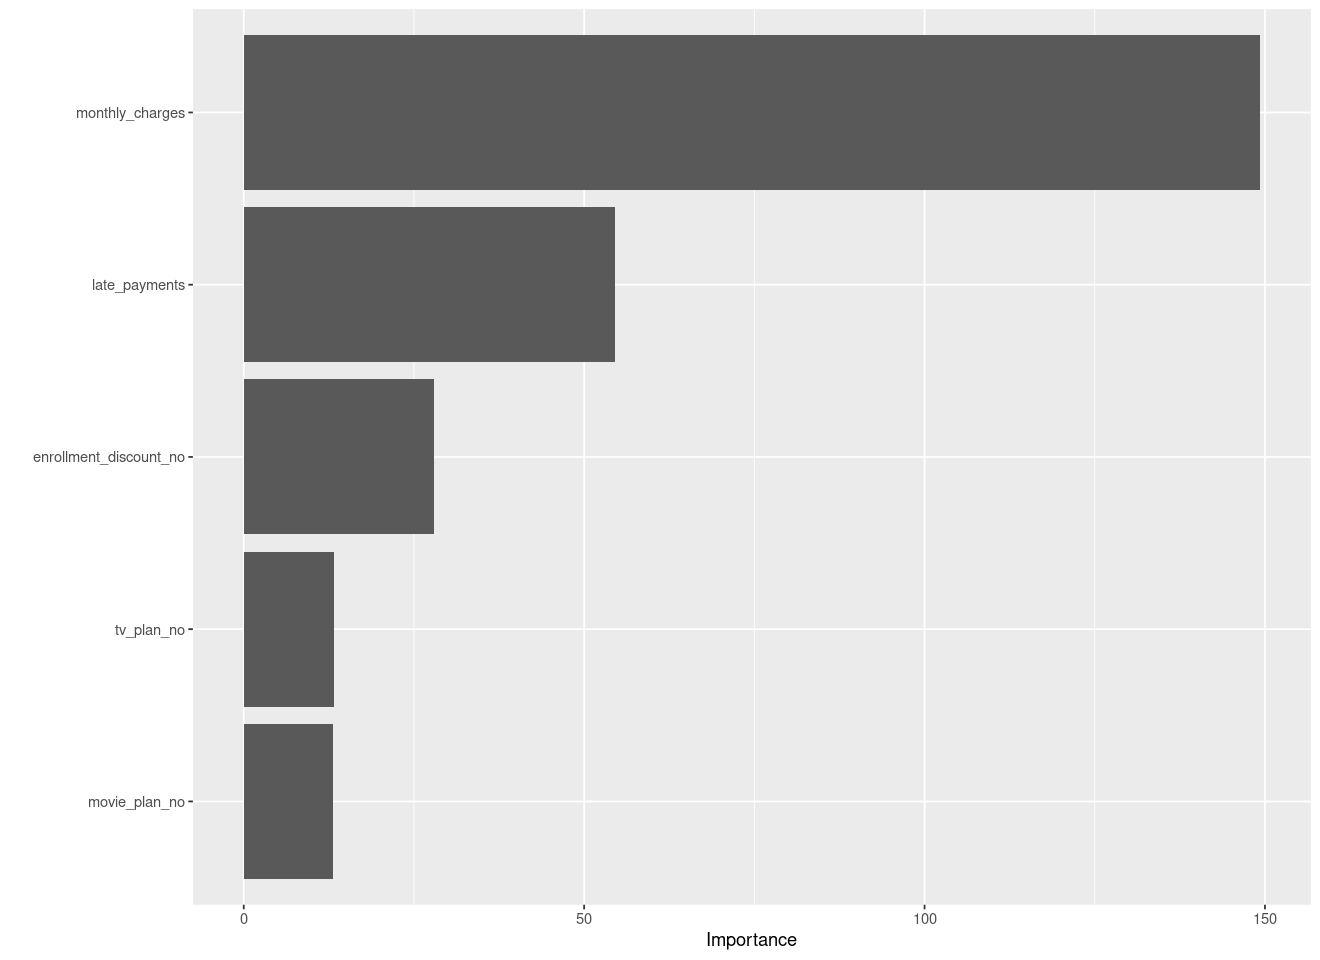

In [50]:
vip(rf_fit)

## Train and Evaluate With `last_fit()`

Next we fit our final model workflow to the training data and evaluate performance on the test data. 

The `last_fit()` function will fit our workflow to the training data and generate predictions on the test data as defined by our `churn_split` object.

In [51]:
rf_last_fit <- 
  final_rf_workflow %>% 
  last_fit(churn_split)

<br>

We can view our performance metrics on the test data

In [52]:
rf_last_fit %>% collect_metrics()

.metric,.estimator,.estimate,.config
<chr>,<chr>,<dbl>,<chr>
accuracy,binary,0.7740864,Preprocessor1_Model1
roc_auc,binary,0.8574269,Preprocessor1_Model1


## ROC Curve 

We can plot the ROC curve to visualize test set performance of our random forest model.

In [ ]:
rf_last_fit %>% collect_predictions() %>% 
                roc_curve(truth  = churn, estimate = .pred_yes) %>% 
                autoplot()


## Confusion Matrix

We see that our model made 38 false negatives and 30 false positives on our test data set.

In [53]:
rf_predictions <- rf_last_fit %>% collect_predictions()

conf_mat(rf_predictions, truth = churn, estimate = .pred_class)

          Truth
Prediction yes  no
       yes  96  30
       no   38 137